Prepare dependencies and global variables

In [9]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D,BatchNormalization
import pickle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from tensorflow import keras

raw_train_dir = "/content/drive/My Drive/dog_cat/raw_train"
train_dir = "/content/drive/My Drive/dog_cat/train"
raw_test_dir = "/content/drive/My Drive/dog_cat/raw_test"
test_dir = "/content/drive/My Drive/dog_cat/test"
train_data_file = "/content/drive/My Drive/dog_cat/train_data"
train_label_file = "/content/drive/My Drive/dog_cat/train_label"
test_data_file = "/content/drive/My Drive/dog_cat/test_data"
trained_model_dir = "/content/drive/My Drive/dog_cat/trained_model"

def gray_out_and_save_image(original_dir, destionation_dir):
  if not os.path.exists(destionation_dir):
    os.makedirs(destionation_dir)
  for file_name in os.listdir(original_dir):
      original_arr = cv2.imread(os.path.join(original_dir, file_name), cv2.IMREAD_GRAYSCALE)
      new_arr = cv2.resize(original_arr, dsize=(80, 80),interpolation = cv2.IMREAD_GRAYSCALE)
      plt.imsave(destionation_dir + "/" + file_name, new_arr, cmap="gray")

def get_train_data_and_label(train_dir):
  data = []
  label = []
  get_label = lambda prefix : int(prefix == 'dog')
  for file_name in os.listdir(train_dir):
        prefix = file_name.split(".")[0]
        labeled = get_label(prefix)
        img_array = cv2.imread(os.path.join(train_dir, file_name), cv2.IMREAD_GRAYSCALE)
        data.append(img_array)
        label.append(labeled)
  return data, label

def serialize_data(data, file_path):
  open(file_path, 'wb').close()
  with open(file_path, "wb") as file:
    pickle.dump(data, file)

def deserialize_data(file_path):
  with open(file_path, "rb") as data_file:
    return pickle.load(data_file)

def transform_label_to_array(labels):
  temp_result = []
  for label in labels:
    if label == 0:
      temp_result.append([0,1])
    else:
      temp_result.append([1,0])
  return np.array(temp_result)

def create_callbacks():
  earlystop = EarlyStopping(patience=10)
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
  return [earlystop, learning_rate_reduction]

def create_cnn_network(input_shape, activate_function="relu"):
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation=activate_function, input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), activation=activate_function))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(128, (3, 3), activation=activate_function))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(512, activation=activate_function))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  opt = keras.optimizers.RMSprop(learning_rate=0.001)
  model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

def save_model(model, save_dir, name):
  if not os.path.exists(save_dir):
    os.makedirs(save_dir)
  model.save(save_dir + "/" + name)

def load_model(trained_model_dir, activation_function):
  return keras.models.load_model(trained_model_dir + "/" + activation_function + "_model.h5")

callbacks = create_callbacks()

Mounted at /content/drive


Transform to grey and store in trained set

This is one time action, so uncommented to run

In [ ]:
# gray_out_and_save_image(raw_train_dir, train_dir)
# gray_out_and_save_image(raw_test_dir, test_dir)

Dump data using pickle to avoid loading so many file for next run

Dump both train, test and label data

This is one time action

In [ ]:
# train_data, label_data = get_train_data_and_label(train_dir)
# test_data, temp = get_train_data_and_label(test_dir)
# serialize_data(train_data, train_data_file)
# serialize_data(label_data, train_label_file)
# serialize_data(test_data, test_data_file)

Prepare data to train

In [10]:
# Load data
train_data = deserialize_data(train_data_file)
label_data = deserialize_data(train_label_file)
test_data = deserialize_data(test_data_file)

# Transform into array and resharp to 3 dimension array with size 80 x 80 x 1
train_data = np.array(train_data).reshape(-1, 80, 80, 1)
test_data = np.array(test_data).reshape(-1, 80, 80, 1)
label_data = np.array(label_data)

# Shuffle train data and label in order to perform train model - 90% train - 10% test
from sklearn.model_selection import train_test_split
data_to_train, data_to_verify, label_to_train, label_to_verify = train_test_split(train_data, label_data, test_size=0.1)

# Divide to matrix with value from 0..1
data_to_train = data_to_train / 255.0
data_to_verify = data_to_verify / 255.0

# Train form label to 1x2 array
label_to_train = transform_label_to_array(label_to_train)
label_to_verify = transform_label_to_array(label_to_verify)

Train and save model with relu activation function

In [ ]:
activation_function = "relu"
model = create_cnn_network(data_to_train.shape[1:], activation_function)
model.fit(data_to_train, label_to_train, epochs=100, batch_size=64, validation_data=((data_to_verify, label_to_verify)), callbacks = callbacks)
save_model(model, trained_model_dir, activation_function + "_model.h5")

Train and save model with sigmoid activation function

In [ ]:
activation_function = "sigmoid"
model = create_cnn_network(data_to_train.shape[1:], activation_function)
model.fit(data_to_train, label_to_train, epochs=100, batch_size=64, validation_data=((data_to_verify, label_to_verify)), callbacks = callbacks)
save_model(model, trained_model_dir, activation_function + "_model.h5")

Train and save model with softplus activation function

In [ ]:
activation_function = "softplus"
model = create_cnn_network(data_to_train.shape[1:], activation_function)
model.fit(data_to_train, label_to_train, epochs=100, batch_size=64, validation_data=((data_to_verify, label_to_verify)), callbacks = callbacks)
save_model(model, trained_model_dir, activation_function + "_model.h5")

In [11]:
all_data = np.copy(train_data)
all_data = all_data / 255.0
all_labels = transform_label_to_array(label_data)

activation_function = "relu"
print(activation_function.upper())
model = load_model(trained_model_dir, activation_function)
print(model.summary())
scores = model.evaluate(data_to_verify, label_to_verify)
print("Result on verify data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))
scores = model.evaluate(all_data, all_labels)
print("Result on all data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))

RELU
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 78, 78, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)  

Get statistic of trained models

In [ ]:
all_data = np.copy(train_data)
all_data = all_data / 255.0
all_labels = transform_label_to_array(label_data)

activation_function = "relu"
print(activation_function.upper())
model = load_model(trained_model_dir, activation_function)
print(model.summary())
scores = model.evaluate(data_to_verify, label_to_verify)
print("Result on verify data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))
scores = model.evaluate(all_data, all_labels)
print("Result on all data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))

activation_function = "sigmoid"
print(activation_function.upper())
model = load_model(trained_model_dir, activation_function)
print(model.summary())
scores = model.evaluate(data_to_verify, label_to_verify)
print("Result on verify data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))
scores = model.evaluate(all_data, all_labels)
print("Result on all data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))

activation_function = "softplus"
print(activation_function.upper())
model = load_model(trained_model_dir, activation_function)
print(model.summary())
scores = model.evaluate(data_to_verify, label_to_verify)
print("Result on verify data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))
scores = model.evaluate(all_data, all_labels)
print("Result on all data")
print("Loss : " + str(scores[0]) + " Accuracy: " + str(scores[1]))

RELU
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 78, 78, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)  

Tensor board

In [ ]:
activation_function = "relu"
model = load_model(trained_model_dir, activation_function)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 78, 78, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [ ]:
activation_function = "relu"
model = load_model(trained_model_dir, activation_function)

@tf.function
def traceme(x):
    return model(x)


logdir = "log"
writer = tf.summary.create_file_writer(logdir)
tf.summary.trace_on(graph=True, profiler=True)
# Forward pass
traceme(tf.zeros((1, 80, 80, 1)))
with writer.as_default():
    tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=logdir)

%load_ext tensorboard
%tensorboard --logdir log

Keras plot

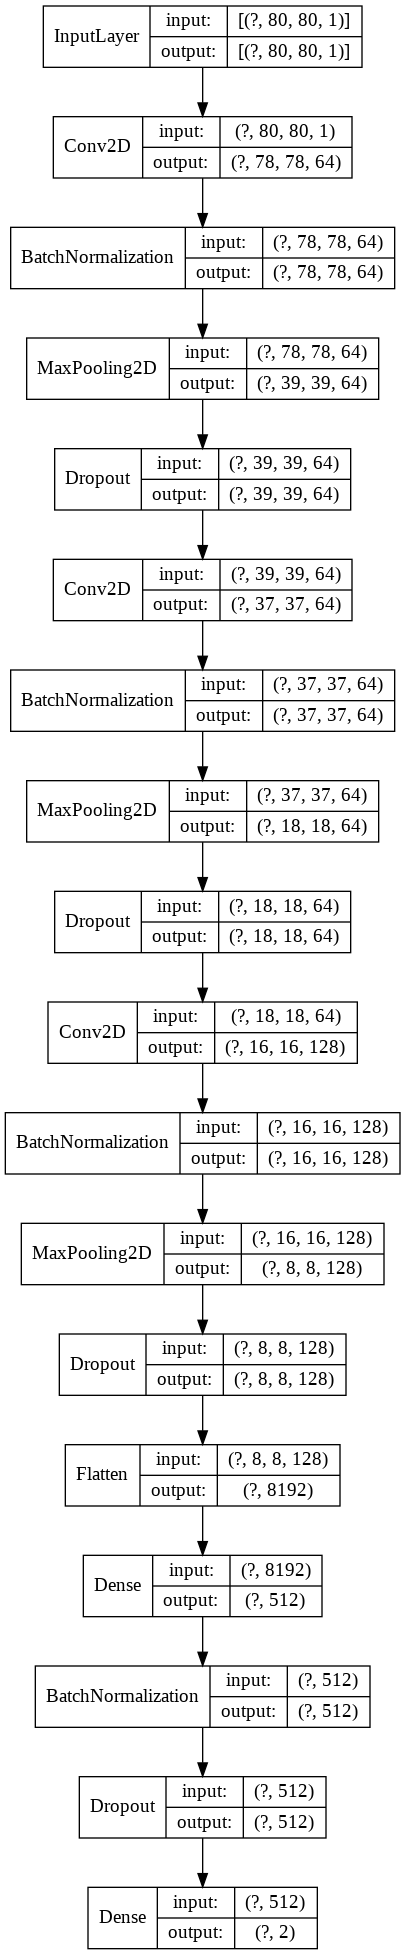

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=False,
    rankdir='TB', expand_nested=True, dpi=96
)

prediction

[[8.358884e-12 1.000000e+00]]


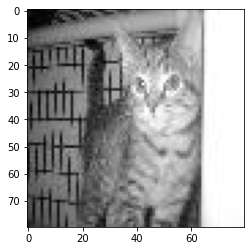

In [ ]:
to_be_test = test_data[11251]
candiadate = np.array(to_be_test).reshape(-1,80,80,1)
print(model.predict(candiadate / 255.0))
plt.imshow(np.squeeze(to_be_test),cmap="gray")

Testing

[[9.998159e-01 1.841273e-04]]


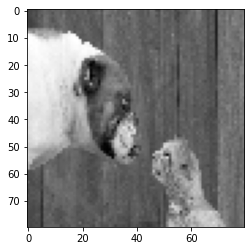

In [21]:
to_be_test = cv2.imread(os.path.join("/content/drive/My Drive/dog_cat/for_testing", 
                                     "dog_and_cats.png"), cv2.IMREAD_GRAYSCALE)
to_be_test = cv2.resize(to_be_test, dsize=(80, 80),interpolation = cv2.IMREAD_GRAYSCALE)
candiadate = np.array(to_be_test).reshape(-1,80,80,1)
print(model.predict(candiadate / 255.0))
plt.imshow(np.squeeze(to_be_test),cmap="gray")